# GTEx Tissue-Specific RNA-seq Analysis
## *Adrenal Gland*

### Data Overview

[The Genotype-Tissue Expression Project](https://gtexportal.org/home/) collects tissue samples from well-genotyped human donors with the aim of better understanding how gene expression and regulation correspond to genetic variation. By analyzing tissue-specific RNA-seq data, it is possible to identify new expression quantitative trait loci (eQTLs) which can provide further insight into the mechanisms through which genetic changes occur in disease states. 

The general notebook template provides a pipeline for the visualization and analysis of gene read counts from the [GTEx v8 Data Release](https://gtexportal.org/home/datasets). Please refer to the [GTEx Documentation](https://gtexportal.org/home/documentationPage) for specifics on how expression and genotype data were obtained. For the purposes of this analysis, the data was further processed as follows:
- non-coding genes were removed by cross-checking with a list of known human genes obtained from the [Gene Database](https://ftp.ncbi.nlm.nih.gov/gene/DATA/GENE_INFO/Mammalia/)
- for genes with multiple associated Ensembl IDs, only the entry with the highest variance across samples was retained
- the data was divided into tissue-specific sub-datasets of counts from the relevant samples
- metadata for the relevant samples of each tissue-specific dataset has been formatted for readability

The final data used for this analysis consists of two datasets: 
- *RNA-seq Data*: provides the read counts of each gene (rows) in each sample (columns). 
- *Sample Metadata*: provides metadata for each sample (rows) such as sex, age range, batch IDs, and more (columns). 
The sample_ids found in the metadata table correspond to the column names of the RNA-seq data.

**Note:** This notebook looks specifically at the data from **Adrenal Gland** tissue samples. 
*For other tissues, please refer to [this repository](https://github.com/MaayanLab/GTExTissueNotebooks).* 

### Analysis Overview 

The RNA-seq data first undergoes normalization and dimensionality reduction via Principle Component Analysis (PCA) and Uniform Manifold Approximation and Projection (UMAP). Samples are then clustered based on their most-associated highly-variable genes and metadata features. The number of clusters is determined based on a modified silhouette score which prioritizes having more clusters over having larger clusters. 

The most up-regulated and down-regulated genes are also identified for each cluster. These genes are used to perform enrichment analysis via the [Enrichr](https://maayanlab.cloud/Enrichr/) API, as well as to search drug signatures that both mimic and reverse each cluster-specific signature via the [L1000FWD](https://maayanlab.cloud/L1000FWD/) API. 

## 0. Notebook Setup
Set appropriate file names and parameters.

In [2]:
import os
import numpy as np
import pandas as pd
import requests
import time
import matplotlib
from matplotlib import pyplot as plt
import seaborn as sns
from umap import UMAP
from scipy.stats import zscore
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm
from maayanlab_bioinformatics.dge import characteristic_direction
from maayanlab_bioinformatics.normalization import log2_normalize, filter_by_var, zscore_normalize
from maayanlab_bioinformatics.utils import merge
import plotly.express as px
import plotly
import math
from collections import OrderedDict
import json
from jupyter_d3 import scatter_plot
from IPython.display import display, IFrame, Markdown, HTML
from textwrap import wrap
from lifelines import KaplanMeierFitter
from lifelines.statistics import multivariate_logrank_test, pairwise_logrank_test
import plotly.graph_objects as go

In [12]:
# dataset selection
data_filename = 'https://appyters.maayanlab.cloud/storage/GTEx_Tissue_RNAseq_Analysis/AdrenalGland_counts_deduped.tsv'
metadata_filename = 'https://appyters.maayanlab.cloud/storage/GTEx_Tissue_RNAseq_Analysis/metadata/metadata_AdrenalGland_counts_deduped.tsv'

In [4]:
# analysis parameters
# defaults are based on defaults used by the Seurat R Package for single cell genomics analysis.

n_pca_components = 10
n_neighbors = 40
min_cluster_dist = 0.3
top_n_genes = 2500
max_clusters_calculation = 'root/2'
use_weighted_silhouette_score = True
use_second_deriv_method = True
top_n_genes_enrichment = 250
heatmap_top_n = 100
top_n_results = 5

In [5]:
# enrichment analysis libraries
use_default_libraries = True
transcription_libraries = []
pathways_libraries = []
ontologies_libraries = []
diseases_drugs_libraries = []
cell_types_libraries = []
miscellaneous_libraries = []
legacy_libraries = []
crowd_libraries = []
top_n_drugs = 5
default_libraries = OrderedDict([
    ('Diseases/Drugs', ['GWAS_Catalog_2019']), 
    ('Ontologies', ['GO_Biological_Process_2018']),
    ('Pathways', ['KEGG_2019_Human']),
    ('Transcription', ['ENCODE_TF_ChIP-seq_2015']),
])

# determine if using default libraries
if use_default_libraries:
    enrichr_libraries = default_libraries
else: 
    enrichr_libraries = OrderedDict([
        ('Diseases/Drugs', diseases_drugs_libraries), 
        ('Ontologies', ontologies_libraries),
        ('Cell Type', cell_types_libraries),
        ('Pathways', pathways_libraries),
        ('Transcription', transcription_libraries),
        ('Legacy', legacy_libraries),
        ('Crowd', crowd_libraries)
    ])
    all_empty = True
    for key,libs in enrichr_libraries.items():
        if len(libs) > 0:
            all_empty = False
            break
    if all_empty:
        enrichr_libraries = default_libraries

In [6]:
# Notebook display util functions
def download_button(content, label, filename):
    # Add download button
    outname = filename.split('.')[0]
    display(HTML('<textarea id="textbox_{outname}" style="display: none;">{content}</textarea> <button style="margin:10px 0;" id="create_{outname}">{label}</button> <a download="{filename}" id="downloadlink_{outname}" style="display: none">Download</a>'.format(**locals())))
    display(HTML('<script type="text/javascript">!function(){{var e=null,t=document.getElementById("create_{outname}"),n=document.getElementById("textbox_{outname}");t.addEventListener("click",function(){{var t,l,c=document.getElementById("downloadlink_{outname}");c.href=(t=n.value,l=new Blob([t],{{type:"text/plain"}}),null!==e&&window.URL.revokeObjectURL(e),e=window.URL.createObjectURL(l)),c.click()}},!1)}}();</script>'.format(**locals())))

def make_clickable(link):
    return f'<a target="_blank" href="{link}">{link}</a>'

def figure_header(label,title):
    display(HTML(f"<div style='font-size:2rem; padding:1rem 0;'><b>{label}</b>: {title}</div>"))
    
def figure_legend(label,title,content=""):
    display(HTML(f"<div style='font-size:1.5rem;'><b>{label}</b>: <i>{title}</i>. {content} </div>"))

## 1. Import Datasets
Load RNA-seq gene read counts and associated sample metadata into dataframes.

In [10]:
def load_dataframe(file):
    ''' Load a file by downloading it or reading it if already downloaded.
    '''
    ext = os.path.splitext(file)[1]
    if ext in {'.tsv', '.txt'}:
        df = pd.read_csv(file, sep='\t', index_col=0)
    elif ext == '.csv':
        df = pd.read_csv(file, index_col=0)
    else:
        raise Exception('Unrecognized file format', ext)

    # Fix any type coersion on identifiers
    df.index = df.index.astype(str)
    df.columns = df.columns.astype(str)

    return df

In [13]:
data_index = "symbol"
metadata_index = "sample_id"

print(f"Loading user-uploaded data...")
df_data = load_dataframe(data_filename).sort_index()
df_metadata = load_dataframe(metadata_filename).sort_index()

df_data.index.name = "symbol"
df_metadata.index.name = "sample_id" 

print("Data loaded\n")

Loading user-uploaded data...
Data loaded



### 1a. RNA-seq Data

In [14]:
figure_legend("Table 1", "RNA-seq data", "The RNA-seq data contains a row per gene and a column per sample. The column indices are unique GTEx sample_ids, while the row indices are Entrez gene symbols.")
display(df_data.head())

,GTEX-111CU-0126-SM-5GZWZ,GTEX-111YS-0126-SM-5987T,GTEX-1122O-0326-SM-5H124,GTEX-117YX-0126-SM-5EGH5,GTEX-11DXX-0126-SM-5EGH7,GTEX-11DXY-1626-SM-5H12L,GTEX-11DXZ-0226-SM-5EGGZ,GTEX-11EM3-0326-SM-5A5KJ,GTEX-11EMC-0526-SM-5EGJN,GTEX-11EQ9-0126-SM-5986I,...,GTEX-ZT9W-0126-SM-4YCFD,GTEX-ZT9X-0126-SM-4YCFC,GTEX-ZTSS-0326-SM-5987M,GTEX-ZUA1-1926-SM-5E45E,GTEX-ZVP2-0126-SM-5NQ7D,GTEX-ZVT2-0826-SM-5GIEO,GTEX-ZY6K-0126-SM-5SIAM,GTEX-ZYFG-0926-SM-5BC5U,GTEX-ZYVF-1626-SM-5N9EH,GTEX-ZZPU-1226-SM-5N9CK
symbol,,,,,,,,,,,,,,,,,,,,,
A1BG,161,77,299,34,172,104,90,48,262,112,...,201,151,130,114,144,93,151,230,214,168
A1CF,8,4,12,1,14,2,6,14,5,0,...,0,11,6,10,2,4,2,12,3,18
A2M,26283,12309,24205,24806,30448,17103,19346,33597,69954,23812,...,41336,21675,21244,25798,47966,51681,29462,32041,21241,36635
A2ML1,29,28,49,25,19,30,32,39,15,24,...,19,29,31,37,12,40,17,64,25,21
A3GALT2,3,3,6,2,2,1,0,3,2,8,...,2,0,7,4,1,5,0,9,1,4


### 1b. Metadata

#### Phenotype Metadata
Three categories of phenotypic attributes are collected and published for each donor on the GTEx portal.
- Sex 
    - **1**=Male
    - **2**=Female
- Age
- Hardy Scale Death Classification 
    - **0**=Ventilator case
    - **1**=Fast and violent death
    - **2**=Fast death from natural causes
    - **3**=Intermediate death
    - **4**=Slow death
    
During preprocessing, the sex and Hardy Scale classifications were re-coded as strings, to increase readability. 

#### Sample Metadata
There are also 62 different sample attributes recorded for each sample, which are described more in-depth [in this Excel spreadsheet](https://storage.googleapis.com/gtex_analysis_v8/annotations/GTEx_Analysis_v8_Annotations_SampleAttributesDD.xlsx). Since not all categories have unique values across all samples, any metadata categories with less than 2 unique values across all samples are removed. On the other hand, categories which have a unique value for every sample aren't very helpful either, so those are removed as well. 

In [15]:
drop_cols = []
for (col, items) in df_metadata.iteritems():
    uniq_vals = len(items.unique()) > 1
    less_than_total = len(items.unique()) < df_metadata.shape[0]
    if not (uniq_vals and less_than_total):
        drop_cols.append(col)
df_metadata = df_metadata.drop(columns=drop_cols)

#### Combined Metadata
In order to gain a more holistic understanding of each sample and the individual from whom it was obtained, the sample and donor metadata were combined during preprocessing by mapping each sample ID from the sample metadata to the matching donor ID in the phenotype metadata, and then prepending the associated phenotype values to the sample metadata dataframe.

In [16]:
figure_legend("Table 3","Combined metadata", "The column indices refer to relevant sample and donor metadata categories, while the row indices are unique GTEx sample IDs corresponding to the columns of the RNA-seq data table. Note that categories with too few or too many unique values were removed in a previous step, causing the number of columns to be less than 65.")
display(df_metadata.head())

,sex,age,dthhrdy,autolysis_score,bss_site,path_notes,rin_num,total_isch_time,paxgene_time,iso_batch_id,...,end2_antisense,alt_align,end2_sense,frag_len_mean,end1_antisense,split_reads,end1_sense,end1_pc_sense,end1_map_rate,end2_pc_sense
sample_id,,,,,,,,,,,,,,,,,,,,,
GTEX-111CU-0126-SM-5GZWZ,M,50-59,Ventilator,0.0,B1,2 pieces,7.9,67.0,642.0,BP-43693,...,18000000.0,15200000.0,18000000.0,259.0,18000000.0,12800000.0,18300000.0,50.3671,0.995748,49.9377
GTEX-111YS-0126-SM-5987T,M,60-69,Ventilator,1.0,B1,3 fragmented pieces; up to 2.5mm external fat ...,8.1,101.0,788.0,BP-44577,...,16000000.0,12000000.0,15700000.0,174.0,15700000.0,10400000.0,16300000.0,50.8151,0.995667,49.4249
GTEX-1122O-0326-SM-5H124,F,60-69,Ventilator,0.0,B1,"2 pieces, one is ~30% adipose tissue",8.7,38.0,965.0,BP-43693,...,20900000.0,12500000.0,20900000.0,274.0,20900000.0,15500000.0,21000000.0,50.0663,0.995925,49.9875
GTEX-117YX-0126-SM-5EGH5,M,50-59,Ventilator,1.0,B1,"2 pieces; well dissected, no fat, focal periad...",7.9,76.0,730.0,BP-44460,...,11900000.0,6820000.0,11800000.0,128.0,11800000.0,8660000.0,12100000.0,50.4863,0.996181,49.7877
GTEX-11DXX-0126-SM-5EGH7,F,60-69,Ventilator,0.0,B1,"2 pieces, mild-moderate medullary hyperplasia",8.8,82.0,531.0,BP-44460,...,13300000.0,7120000.0,13200000.0,139.0,13300000.0,10800000.0,13500000.0,50.3911,0.996413,49.8199


Listed below are all the metadata categories with at least two unique values across the samples, but less than the total number of samples. These will be relevant during the dimensionality reduction and clustering steps.

In [17]:
features = df_metadata.columns.values
print(features)

['sex' 'age' 'dthhrdy' 'autolysis_score' 'bss_site' 'path_notes' 'rin_num'
 'total_isch_time' 'paxgene_time' 'iso_batch_id' 'iso_batch_type'
 'iso_batch_date' 'gtype_batch_id' 'gtype_batch_date' 'end2_map_rate'
 'intragenic_rate' 'map_rate' 'exon_rate' 'genes_detec' 'frag_len_std'
 'mapped' 'num_rrna' 'total_reads' 'failed_qc' 'trans_detec'
 'mapped_pairs' 'map_uniq_rate' 'mapped_uniq' 'end2_mismatch'
 'end2_antisense' 'alt_align' 'end2_sense' 'frag_len_mean'
 'end1_antisense' 'split_reads' 'end1_sense' 'end1_pc_sense'
 'end1_map_rate' 'end2_pc_sense']


## 2. Normalize Data
Given the highly variable nature of expression level between different genes, it is necessary to normalize the read counts before proceeding.

In [18]:
# Data size stats
df_library_size = pd.DataFrame(
    {
        'n_reads': df_data[df_data > 0].count(),
        'log_n_reads': np.log2(df_data[df_data > 0].count() + 1),
        'n_expressed_genes': df_data.sum(),
    }).sort_values('n_reads', ascending=False)

df_library_size.index.name = "sample_id"

In [19]:
figure_legend("Table 4","Library size", "By default, the first five entries are shown. A gene read is counted toward n_reads for a single sample if its value is greater than 0.")
display(df_library_size.head()) 

,n_reads,log_n_reads,n_expressed_genes
sample_id,,,
GTEX-S341-0126-SM-4AD64,17311,14.079485,51942124
GTEX-S3XE-0126-SM-4AD4R,17073,14.059513,61113044
GTEX-14A5H-2126-SM-7IGNV,17024,14.055367,34459740
GTEX-1H3VY-1826-SM-9JGI4,16993,14.052738,82334464
GTEX-S32W-0126-SM-4AD61,16992,14.052653,47516781


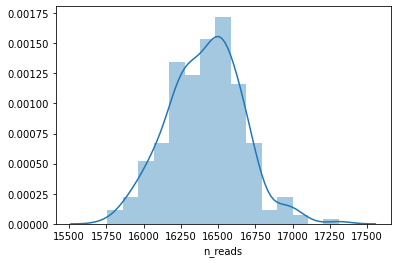

In [20]:
figure_legend("Figure 1","Library size distribution")
sns.distplot(df_library_size["n_reads"]); plt.show()

Two versions of the dataset are normalized: one with just the `top_n_genes` most variable genes and one with all genes. The former will be used to compute clusters after dimensionality reduction, and the latter to compute the characteristic direction (up or down) of each gene in a cluster. 

In [21]:
# Normalization

# maintain the unfiltered dataset to compute characteristic directions later
df_data_norm_all_genes = df_data.copy()

# take top_n_genes most variable rows
df_data_norm = filter_by_var(df_data,top_n = top_n_genes)

# compute log normalization of matrix
df_data_norm = log2_normalize(df_data_norm)
df_data_norm_all_genes = log2_normalize(df_data_norm_all_genes)

# convert to zscores
df_data_norm = zscore_normalize(df_data_norm)
df_data_norm_all_genes = zscore_normalize(df_data_norm_all_genes)

In [22]:
print("Normalized dataset with all genes has shape ",df_data_norm_all_genes.shape)
print(f"Normalized dataset with {top_n_genes} most variable genes has shape ", df_data_norm.shape)

Normalized dataset with all genes has shape  (18497, 258)
Normalized dataset with 2500 most variable genes has shape  (2500, 258)


In [23]:
figure_legend("Table 5","Normalized RNA-seq data", "Counts are filtered for the <i>top_n_genes</i> most variable genes. A log transform and normalization is performed on the resultitng dataset, which is then converted to z-scores.")
display(df_data_norm)

,GTEX-111CU-0126-SM-5GZWZ,GTEX-111YS-0126-SM-5987T,GTEX-1122O-0326-SM-5H124,GTEX-117YX-0126-SM-5EGH5,GTEX-11DXX-0126-SM-5EGH7,GTEX-11DXY-1626-SM-5H12L,GTEX-11DXZ-0226-SM-5EGGZ,GTEX-11EM3-0326-SM-5A5KJ,GTEX-11EMC-0526-SM-5EGJN,GTEX-11EQ9-0126-SM-5986I,...,GTEX-ZT9W-0126-SM-4YCFD,GTEX-ZT9X-0126-SM-4YCFC,GTEX-ZTSS-0326-SM-5987M,GTEX-ZUA1-1926-SM-5E45E,GTEX-ZVP2-0126-SM-5NQ7D,GTEX-ZVT2-0826-SM-5GIEO,GTEX-ZY6K-0126-SM-5SIAM,GTEX-ZYFG-0926-SM-5BC5U,GTEX-ZYVF-1626-SM-5N9EH,GTEX-ZZPU-1226-SM-5N9CK
symbol,,,,,,,,,,,,,,,,,,,,,
CYP11B1,3.609119,4.180137,3.916906,3.736459,3.898186,3.980013,4.841515,3.695198,5.454761,3.640738,...,2.815373,3.891508,3.596605,3.877246,2.596766,3.530745,3.063595,3.427459,4.564388,3.402979
CYP17A1,4.036132,4.572690,4.506577,4.498618,4.585007,2.957479,5.406543,4.023579,4.066182,4.399751,...,3.361010,4.569208,4.318827,1.830793,3.923764,3.947039,4.432533,3.629921,3.450432,4.142220
STAR,3.168773,3.281117,3.154111,3.358976,3.366698,2.098653,4.017257,3.385351,3.400734,3.222304,...,2.583092,3.614248,3.089002,1.877591,2.201743,2.917285,2.950804,2.519632,2.762748,2.679368
SCARB1,1.679193,2.239377,2.473952,2.083834,2.395433,1.940502,3.192241,2.416055,3.569758,2.311921,...,1.394446,2.772472,1.875299,2.018752,1.662150,2.233069,2.093399,1.865464,3.670141,2.123090
HSD3B2,1.951355,2.484039,2.152382,2.720525,2.767684,2.299271,2.701547,3.239343,3.111592,2.482484,...,2.233144,1.429932,2.094115,2.331185,0.547212,2.902733,1.024659,2.185662,2.631285,1.842135
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
MAPK14,-0.398759,-0.474629,-0.537943,-0.444272,-0.699536,-0.255467,-0.600991,-0.398887,-0.699760,-0.509570,...,-0.376256,-0.287011,-0.476142,-0.407188,-0.378957,-0.291566,-0.235508,-0.342721,-0.401394,-0.454285
RAB11B,-0.028144,0.017774,-0.125904,-0.119681,-0.200276,0.015443,-0.117602,-0.088202,0.030547,0.026692,...,-0.091901,-0.202824,-0.052842,0.068932,-0.169240,-0.143193,-0.222304,-0.150558,-0.056192,0.037456
ARHGEF3,-0.142124,-0.330691,-0.177312,-0.186006,-0.227147,-0.288840,-0.119959,-0.117269,-1.175746,-0.125299,...,-0.246653,-0.052799,-0.091758,-0.143421,0.014433,-0.240221,-0.048552,-0.180455,-0.525723,-0.306161


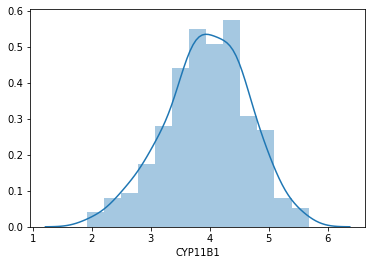

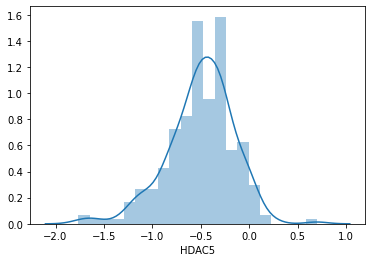

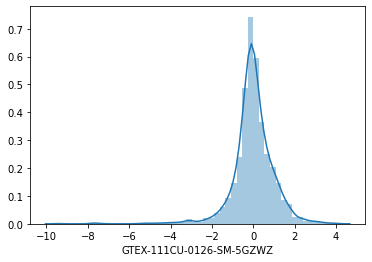

In [24]:
# plot the first gene distribution
gene = df_data_norm.index.values[0]
sns.distplot(df_data_norm.iloc[0, :]); plt.show()
figure_legend("Figure 2",f"Sample gene expression distibution for {gene}", f"In this dataset, {gene} is the most variably expressed across all samples.")

# plot the last gene distribution
gene = df_data_norm.index.values[-1]
sns.distplot(df_data_norm.iloc[-1, :]); plt.show()
figure_legend("Figure 3",f"Sample gene expression distibution for {gene}", f"In this dataset, {gene} is the least variably expressed across all samples among the 2500 most variably expressed genes.")

# plot a single RNA seq profile distribution
sns.distplot(df_data_norm.iloc[:, 0]); plt.show()
figure_legend("Figure 4","Sample individual RNA-seq profile distribution")

## 3. Reduce Data Dimensionality

Now that the data has been loaded and normalized, the most variable genes across the dataset can be identified and visualized with hierachical clustering and heatmaps. Dimensionality reduction facilitates the differentiation of the data in a more efficient manner by reducing the number of attributes to be considered. 

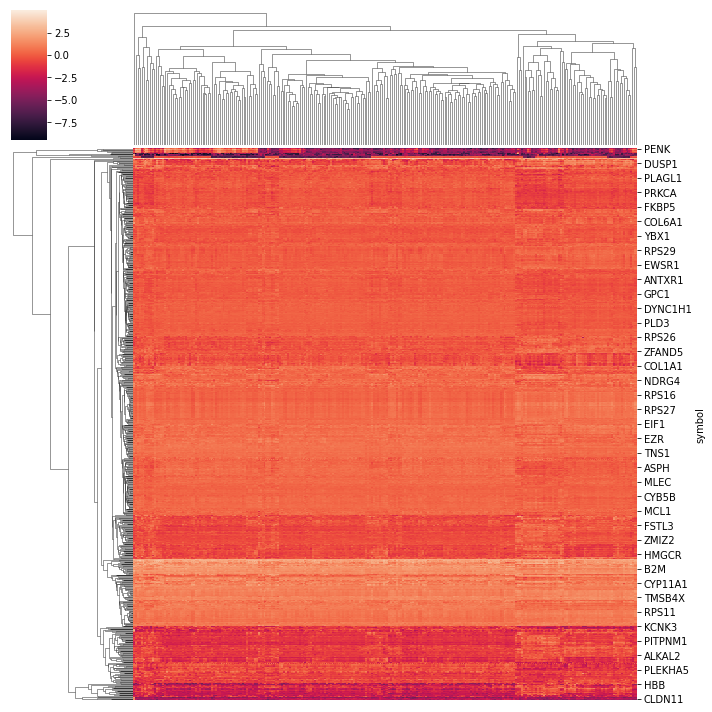

In [25]:
# Normalization
# take top 800 most variable rows

# the "i" in the variable here stands for "initial", since we'll do a different method 
# for selecting genes for a heatmap later
df_data_norm_heatmap_i = filter_by_var(df_data,top_n=800)

# compute log normalization of matrix
df_data_norm_heatmap_i = log2_normalize(df_data_norm_heatmap_i)

# convert to zscores
df_data_norm_heatmap_i = zscore_normalize(df_data_norm_heatmap_i) 

# Plot heatmap
sns.clustermap(df_data_norm_heatmap_i,xticklabels=False); plt.show()
figure_legend("Figure 5","Heatmap of normalized expression for top 800 most variable genes", "This initial heatmap considers only the top most variable genes across the entire dataset, rather than the most differentially expressed genes among potential clusters. As such, there may seem to be a lot of noise preventing us from seeing clear clusters. This will be amended in a later heatmap.")


### 4a. Principle Component Analysis 
PCA is used first to reduce the dimensionality of the dataset, while still maintaining most of the variability.

In [26]:
# PCA
data_norm_pca = PCA(
  random_state=42,
)

data_norm_pca.fit(df_data_norm.values.T)

df_data_norm_pca = pd.DataFrame(
    data_norm_pca.transform(df_data_norm.values.T),
    index=df_data_norm.T.index
)

df_data_norm_pca.columns = [
    f'PCA-{c}' # ({r:.3f})'
    for c, r in zip(df_data_norm_pca.columns, data_norm_pca.explained_variance_ratio_)
]

df_data_norm_pca.index.name = "sample_id"

In [27]:
figure_legend("Table 6","Principle components of RNA-seq data", "The top principle components are the projections of each datapoint onto the axes along which there is the most variation in the dataset.")
display(df_data_norm_pca.head())

,PCA-0,PCA-1,PCA-2,PCA-3,PCA-4,PCA-5,PCA-6,PCA-7,PCA-8,PCA-9,...,PCA-248,PCA-249,PCA-250,PCA-251,PCA-252,PCA-253,PCA-254,PCA-255,PCA-256,PCA-257
sample_id,,,,,,,,,,,,,,,,,,,,,
GTEX-111CU-0126-SM-5GZWZ,-14.768368,12.751851,7.971698,-6.185266,5.411045,-1.579873,-0.658464,0.207574,-1.644784,-3.803440,...,-0.019009,-0.381777,0.278975,-0.172343,-0.213221,0.091563,-0.059046,0.070603,-0.237105,1.680600e-14
GTEX-111YS-0126-SM-5987T,-3.134173,-7.370121,4.468851,-1.407656,-3.763854,-0.732136,-3.175939,-2.433271,1.399663,0.845161,...,0.418265,0.032904,0.089183,-0.049463,0.175507,0.047532,0.141155,-0.165845,0.347791,1.616762e-14
GTEX-1122O-0326-SM-5H124,-16.541426,18.209572,0.338238,2.914631,-2.406355,1.085764,-4.124334,2.876215,-1.739295,3.020506,...,0.217141,-0.049094,-0.280910,0.191057,-0.221025,-0.251702,-0.080311,-0.415120,-0.017164,1.543210e-14
GTEX-117YX-0126-SM-5EGH5,1.610159,-11.149366,1.452024,-0.337644,-2.449073,-3.547682,2.107324,5.870010,-1.323868,-0.345167,...,-0.300893,0.191891,-0.432447,-0.363759,-0.099068,-0.089218,0.112953,0.186413,-0.269460,1.548761e-14
GTEX-11DXX-0126-SM-5EGH7,-15.505058,20.652607,-1.345347,3.414499,2.129851,0.606721,0.249574,5.013069,-3.738594,3.102474,...,-0.166625,0.185264,-0.079262,-0.295761,0.107347,-0.244900,0.324758,0.539039,0.264584,1.709743e-14


In [28]:
pca_data = merge(
        df_data_norm_pca[["PCA-0", "PCA-1"]],
        df_library_size,
        df_metadata
      )

axes = {
    "x": [min(df_data_norm_pca["PCA-0"])*1.1, max(df_data_norm_pca["PCA-0"])*1.1],
    "y": [min(df_data_norm_pca["PCA-1"])*1.1, max(df_data_norm_pca["PCA-1"])*1.1]
}

scatter_plot(pca_data,"PCA-0", "PCA-1",axes,features)
figure_legend("Figure 6","Projection of RNA-seq data onto first two principle directions", "The size of datapoints corresponds to the number of gene reads. Points can be color-coded by any of the metadata categories using the dropdown menu.")

### 4b. Uniform Manifold Approximation and Projection

The dimensionality of the dataset is further reduced by performing UMAP on the data projected onto the first `n_pca_components` PCA components.

In [29]:
# UMAP
data_norm_umap = UMAP(
  random_state=42,
  n_components=2,
  n_neighbors=n_neighbors,
  metric='cosine',
  min_dist=min_cluster_dist,
)

# use top n_pca_components components of PCA
n_pca_components = min(n_pca_components,df_data_norm_pca.shape[1])
data_norm_umap.fit(df_data_norm_pca.iloc[:, :n_pca_components].values)

df_data_norm_umap = pd.DataFrame(
  data_norm_umap.transform(df_data_norm_pca.iloc[:, :n_pca_components].values),
  columns=['UMAP-0', 'UMAP-1'],
  index=df_data_norm_pca.index,
)

In [30]:
# project data onto its first 2 UMAP components for visualization
umap_data = merge(
        df_data_norm_umap[["UMAP-0", "UMAP-1"]],
        df_library_size,
        df_metadata
      )

axes = {
    "x": [min(df_data_norm_umap["UMAP-0"])*1.1, max(df_data_norm_umap["UMAP-0"])*1.1],
    "y": [min(df_data_norm_umap["UMAP-1"])*1.1, max(df_data_norm_umap["UMAP-1"])*1.1]
}

In [31]:
scatter_plot(umap_data,"UMAP-0", "UMAP-1",axes,features)
figure_legend("Figure 7","First two UMAP components of RNA-seq data", "The size of datapoints corresponds to the number of gene reads. Points can be color-coded by any of the metadata categories using the dropdown menu.")

## 5. Clustering

The first two UMAP components will be used from here on out. 

To compute sample clusters, the k-means method is used. The total number of clusters must be determined, by first testing a range for the number of total clusters, and then computing silhouette scores, which are a measure of how similar an entry is to its own cluster versus other clusters. The goal is to maximize both the similarity within a cluster and the differences between clusters, so the ideal number of clusters is that which produces the highest silhouette score.

Here, the selection of $k$ is modified slightly to preserve nuances in the data by prioritizing more clusters over fewer. A modified silhouette score is also calculated, which takes into account the number of clusters $k$; each original score is bumped by a factor linear with respect to $k$. 

In [32]:
def plot_silhouette_analysis(n_clusters, data, cluster_labels, avg_score, sample_values, centers):
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(X[:, 0], X[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')

    # Draw white circles at cluster centers
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(("Silhouette analysis for k-means clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

In [33]:
silhouette_scores = []

# Set max clusters as a function of the sample size and the user-selected option
max_clusters = math.ceil(df_data_norm_umap.shape[0]**0.5)
if (max_clusters_calculation == "root/2"):
    max_clusters = int(math.ceil(max_clusters/2))


def calc_weighted_score(silhouette_score, k, max_k):
    return silhouette_avg*0.7 + k/max_k*0.3

cluster_range = range(2, max_clusters)
for n in cluster_range:
    X = df_data_norm_umap.values
    clusterer = KMeans(n_clusters=n, random_state=42).fit(X)
    y_pred = clusterer.predict(X)
    
    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, y_pred, metric='cosine')
    
    # Compute a weighted score that rewards higher numbers of clusters
    weighted_score = calc_weighted_score(silhouette_avg, n, max_clusters)
    
    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, y_pred)

    silhouette_scores.append({
        "N Clusters": n,
        "Silhouette Score": silhouette_avg,
        "Weighted Score": weighted_score
    })
    
    # Labeling the clusters
    centers = clusterer.cluster_centers_
    
    # Plot the analysis for this number of clusters
    #plot_silhouette_analysis(n, X, y_pred, silhouette_avg, sample_silhouette_values, centers)

If using the "second derivative method" for ideal $k$ calculation, estimates of the second derivatives at each possible point can be computed to see if there are local maxima that may present better values of $k$ than the silhouette scores suggest. If such maxima exist, the value of $k$ that presents the most negative approximated second derivative (meaning the plot of scores is most concave *down* at this value of $k$) is chosen. 

To calculate the second derivatives, the following approximation is used:

$$ f''(x) \approx \frac{f(x+h) - 2f(x) + f(x-h)}{h^2}$$

where, in this case, $h = 1$.

In [34]:
points = {}
threshold = 0.3
score_type = "Silhouette Score"
if use_weighted_silhouette_score:
    score_type = "Weighted Score"
    
for s in silhouette_scores:
    points[s["N Clusters"]] = s[score_type]

# No local maxima - resort to previous method of best score calculation
k = None

if (use_second_deriv_method):
    local_maxima = []
    # Collect all local maxima
    for n in range(cluster_range[1], cluster_range[-2]):
        if points[n] > threshold and points[n-1] < points[n] and points[n+1] < points[n]:
            local_maxima.append(n)
    
    if len(local_maxima)>0:
        print("K values for local maxima and positive silhouette score: ", local_maxima)
    else:
        print("No local maxima with positive silhouette scores found")

    # Otherwise, calculate which of the local max is most concave down (i.e. largest second derivative)
    if len(local_maxima) > 0:
        running_max = 0
        for maxima in local_maxima:
            # approximate the second derivative, with step size = 1
            second_deriv = points[maxima + 1] -  2*points[maxima] + points[maxima-1]
            if second_deriv < running_max:
                running_max = second_deriv
                k = maxima

No local maxima with positive silhouette scores found


In [35]:
silhouette_scores = pd.DataFrame(silhouette_scores)

figure_legend("Table 7", "Silhouette scores by number of clusters", "Values are sorted by the highest silhouette score.")
display(silhouette_scores.sort_values(["Silhouette Score", "Weighted Score"], ascending=False).reset_index().head())

best_score = silhouette_scores.sort_values('Silhouette Score').iloc[-1].to_dict()
best_weighted = silhouette_scores.sort_values('Weighted Score').iloc[-1].to_dict()

best = {"Silhouette Score": best_score, "Weighted Score": best_weighted}

,index,N Clusters,Silhouette Score,Weighted Score
0,0,2,0.704100,0.559537
1,4,6,0.361407,0.452985
2,5,7,0.334124,0.467220
3,3,5,0.329976,0.397650
4,1,3,0.316511,0.321558


In [36]:
if not k:
    k = int(best["Silhouette Score"]["N Clusters"])
    if (use_weighted_silhouette_score):
        k = int(best["Weighted Score"]["N Clusters"])
    
print(f"Ideal k: {k} clusters")

Ideal k: 2 clusters


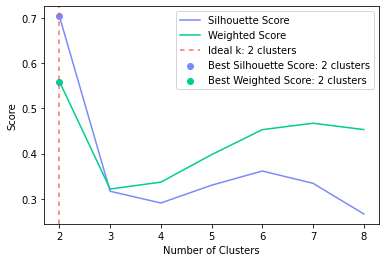

In [37]:
# plot both the uneqeighted and weighted scores as a function of # of clusters
colors = {"Silhouette Score": "#7C88FB", "Weighted Score": "#00CC96"}

for score_type in ['Silhouette Score', 'Weighted Score']:
    plt.plot(silhouette_scores['N Clusters'], silhouette_scores[score_type], label=score_type,color=colors[score_type])
    plt.scatter([best[score_type]['N Clusters']], [best[score_type][score_type]], label=f"Best {score_type}: {int(best[score_type]['N Clusters'])} clusters",color=colors[score_type])
plt.axvline(k, label = f"Ideal k: {k} clusters", color ="#EF553B", alpha=0.8,dashes=(3,3))
plt.legend()
plt.ylabel('Score')
plt.xlabel('Number of Clusters')
plt.show()
figure_legend("Figure 8", "Cluster size selection", "The dotted line indicates the value of the 'ideal' <i>k</i> as chosen by the selected scoring method. This value will be used in subsequent clustering.")

In [38]:
# Compute the k-means dataframe using the ideal number of clusters
km = KMeans(n_clusters=k, random_state=42)
km_clusters = km.fit_predict(df_data_norm_umap.values)

df_data_norm_km = pd.DataFrame({
'Cluster': [
    str(c)
    for c in km_clusters
]}, index=df_data_norm_umap.index)


print(f'Computed {len(df_data_norm_km["Cluster"].unique())} clusters')

Computed 2 clusters


In [39]:
figure_legend("Table 8", "Clusters of first five samples.")
df_data_norm_km.head()

,Cluster
sample_id,
GTEX-111CU-0126-SM-5GZWZ,0
GTEX-111YS-0126-SM-5987T,0
GTEX-1122O-0326-SM-5H124,1
GTEX-117YX-0126-SM-5EGH5,0
GTEX-11DXX-0126-SM-5EGH7,1


In [40]:
# Map each cluster to a color for later plots
clusters = df_data_norm_km["Cluster"].unique()
#plotly_colors = px.colors.qualitative.Plotly
plotly_colors = ['#636EFA', '#EF553B', '#00CC96', '#AB63FA', '#FFA15A', '#19D3F3', '#FF6692', '#B6E880', '#FF97FF', '#FECB52']
cluster_colors = {}
i = 0
for c in clusters:
    cluster_colors[c] = plotly_colors[i % len(plotly_colors)]
    i += 1

def cluster_heading(cluster):
    display(HTML(f'''
    <center>
    <div style='background-color:{cluster_colors[cluster] + '98'};
        width:100%;height:3rem;display:flex;align-items:center;
        justify-content:center;color:white;font-size:2rem'>
        <center>Cluster {cluster}</center>
    </div>
    </center>'''))
    

Next, the differential expression for each cluster is computed. The <a href="http://www.maayanlab.net/CD/">Characteristic Direction method</a> is used for identifying differentially expressed genes among the different clusters.

In [41]:
# Get differential expression for each cluster, using the dataset containing all genes
diff_expr = {}
for cluster, samples in df_data_norm_km.groupby('Cluster'):
    diff_expr[f"Cluster {cluster} CD"] = characteristic_direction(
        # expression outside of this cluster
        df_data_norm_all_genes.loc[:, df_data_norm_all_genes.columns.difference(samples.index)],
        # expression in this cluster
        df_data_norm_all_genes.loc[:, samples.index],
      )['CD-coefficient']

df_diff_expr = pd.DataFrame(diff_expr)
df_diff_expr = df_diff_expr.sort_values(by='Cluster 0 CD',ascending=True)
df_diff_expr['Symbol'] = df_diff_expr.index.values

In [42]:
figure_legend("Table 9", "Differential expression of genes by cluster", "By default, the top 5 most differentially expressed genes are shown, along with the corresponding characteristic directions for each cluster.")
display(df_diff_expr.head())

,Cluster 0 CD,Cluster 1 CD,Symbol
SMR3B,-0.051847,0.051847,SMR3B
KRT72,-0.049643,0.049643,KRT72
ZNF534,-0.044335,0.044335,ZNF534
ZDHHC22,-0.040471,0.040471,ZDHHC22
CHRNA6,-0.040126,0.040126,CHRNA6


Logistic regression is performed for each metadata category to determine which categories most accurately predict cluster designations for each data point. ROC curves are also plotted for categories with top five highest AUC scores.

In [43]:
# LR
aucs = {}
num_rocs_plotted = 0
rocs = {}

for cluster, samples in df_data_norm_km.groupby('Cluster'): 
    aucs[cluster] = {}
    rocs[cluster] = []

    for feature in features:
        lr = LogisticRegression()
        X = df_metadata.copy()
        X = X[feature]
        X = pd.merge(X, df_data_norm_km, left_index = True, right_index = True)

        # drop NAs, and move on if dataset is empty
        X.replace("not reported", None)
        X = X.dropna()
        if (X.shape[0] == 0): continue

        cluster_data = X["Cluster"]
        X = X.drop(columns= ["Cluster"])

        # one-hot encode non numerical data
        if (not isinstance(X[feature][0], (int, float, complex))):
            X = pd.get_dummies(X[feature], prefix=feature)

        y_true = (cluster_data == cluster)
        
        if (len(y_true.unique()) < 2): # if there is only one class in the dataset
            print(f"Not enough data to classify cluster {cluster} based on category {feature}")
            aucs[cluster][feature] = np.nan
            continue 
                  
        lr.fit(X, y_true)

        y_score = lr.predict_proba(X)[:, 1]
        auc_score = roc_auc_score(y_true, y_score)
        aucs[cluster][feature] = auc_score
        
        # save the ROCs
       
        rocs[cluster].append({"auc":auc_score, "lr": lr, "X": X, "y_true":y_true, "title": f'Predictions of cluster {cluster} by category {feature}'})
        
df_cluster_aucs = pd.DataFrame(aucs)
df_cluster_aucs.index.name="Category"

# sort features by avg AUC across all clusters
df_cluster_aucs["avg"] = [ np.mean(df_cluster_aucs.T[f]) for f in df_cluster_aucs.index.values ]
df_cluster_aucs = df_cluster_aucs.sort_values(by = "avg", ascending=False)
df_cluster_aucs = df_cluster_aucs.drop(columns = "avg")

cols = [('Cluster', col) for col in df_cluster_aucs.columns ]
df_cluster_aucs.columns = pd.MultiIndex.from_tuples(cols)

In [44]:
figure_legend("Table 10", "Average AUC scores for top predictive metadata categories, by cluster", "Scores for the top 10 metadata categories for predicting clusters, as determined by the average AUC score across all clusters, are shown. Higher AUC scores correspond to better classifiers for distinguishing whether or not a datapoint belongs to a certain cluster.")
display(df_cluster_aucs.head(10))

Cluster          
                         0         1
Category                            
path_notes        0.999852  0.999852
iso_batch_id      0.970678  0.970678
iso_batch_date    0.944613  0.944613
sex               0.924324  0.924324
gtype_batch_id    0.895548  0.895548
gtype_batch_date  0.859440  0.859440
rin_num           0.771344  0.771344
intragenic_rate   0.715291  0.715291
end2_pc_sense     0.714846  0.714846
total_isch_time   0.702444  0.702444

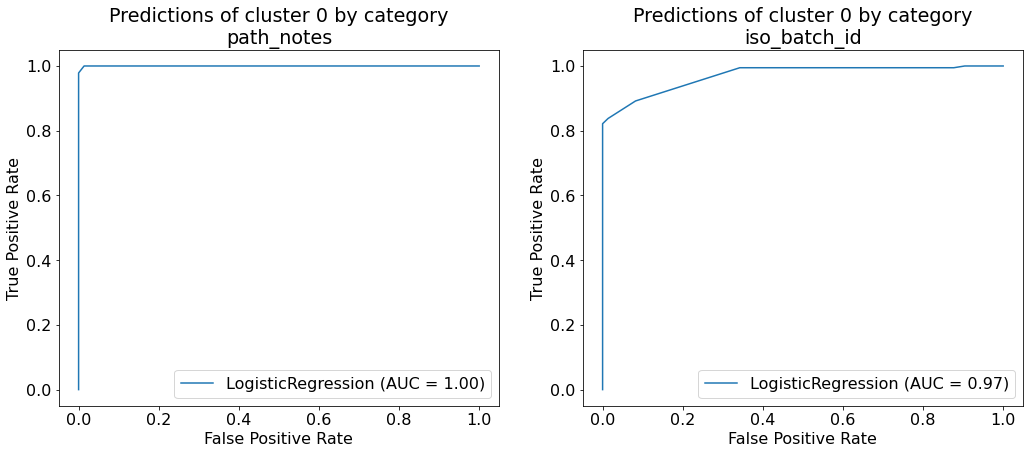

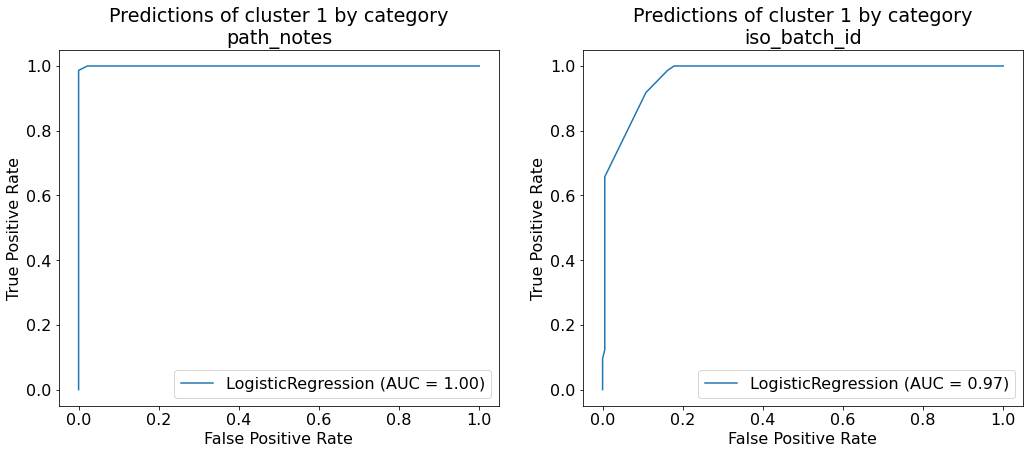

In [45]:
# plot top 2 (or however many exist) ROCs for each cluster
matplotlib.rc('font', size=16)

for cluster, plots in rocs.items():
    plots.sort(reverse=True, key=lambda x: x["auc"])
    cluster_heading(cluster)
    
    if len(plots) < 2:
        best_rocs = plots
    else:
        best_rocs = plots[:2]

    num_plots = len(best_rocs)
    figure,axes = plt.subplots(int(math.ceil(num_plots / 2.)), 2, figsize=(15,(len(best_rocs)*3.5)))
    
    axes = axes.flatten()
    for i in range(len(axes)):
        if i >= len(best_rocs):
            axes[i].remove()
        else:
            plot = best_rocs[i]
            fig = metrics.plot_roc_curve(plot["lr"], plot["X"], plot["y_true"], ax=axes[i])

            axes[i].set_title('\n'.join(wrap(plot["title"], 40)))

    figure.tight_layout(pad=2)
    plt.show()
    
figure_legend("Figure 9", "ROCs for top cluster-predicting metadata categories")

matplotlib.rcdefaults()

## 6. Identify Up- and Down-Regulated Genes
Find the most up- and down-regulated genes for each cluster for visualization in heatmap, and for enrichment analysis. 

In [46]:
# Merge data
df_clustered_umap = pd.merge(left=df_data_norm_km, left_on="sample_id", right=df_data_norm_umap, right_on="sample_id")
df_clustered_pca = pd.merge(left=df_data_norm_km, left_on="sample_id", right=df_data_norm_pca, right_on="sample_id")

In [47]:
# Get top Genes for each cluster
top_genes = {}
all_top_genes = []
heatmap_top_n = min(heatmap_top_n, top_n_genes_enrichment)
for cluster in df_clustered_umap['Cluster'].unique():
    cd_col = f'Cluster {cluster} CD'
    if cd_col in df_diff_expr.columns:
        # top up genes
        up_genes = df_diff_expr.loc[df_diff_expr[cd_col].sort_values(ascending=False).iloc[:top_n_genes_enrichment].index, 'Symbol'].values
        # top down genes
        dn_genes = df_diff_expr.loc[df_diff_expr[cd_col].sort_values(ascending=True).iloc[:top_n_genes_enrichment].index, 'Symbol'].values
    else:
        raise Exception('Cant find col for cluster')
    all_top_genes.append(up_genes[:heatmap_top_n])
    all_top_genes.append(dn_genes[:heatmap_top_n])
    # save results
    top_genes[cluster] = (up_genes, dn_genes)
all_top_genes = [item for sublist in all_top_genes for item in sublist]  # flatten all genes to one list

Data corresponding to only the `heatmap_top_n` up- and down-regulated genes for each cluster is selected for visualization in a heatmap, with log-transformation and normalization proceeding as before. 

In [48]:
df_data_norm_heatmap_f = df_data.loc[all_top_genes, :]

# compute log normalization of matrix
df_data_norm_heatmap_f = log2_normalize(df_data_norm_heatmap_f)

# convert to zscores
df_data_norm_heatmap_f = zscore_normalize(df_data_norm_heatmap_f) 

# Plot heatmap
cases = df_data_norm_heatmap_f.columns
heatmap_cluster_colors = [ cluster_colors[x] for x in df_clustered_umap.loc[cases, :]["Cluster"] ]

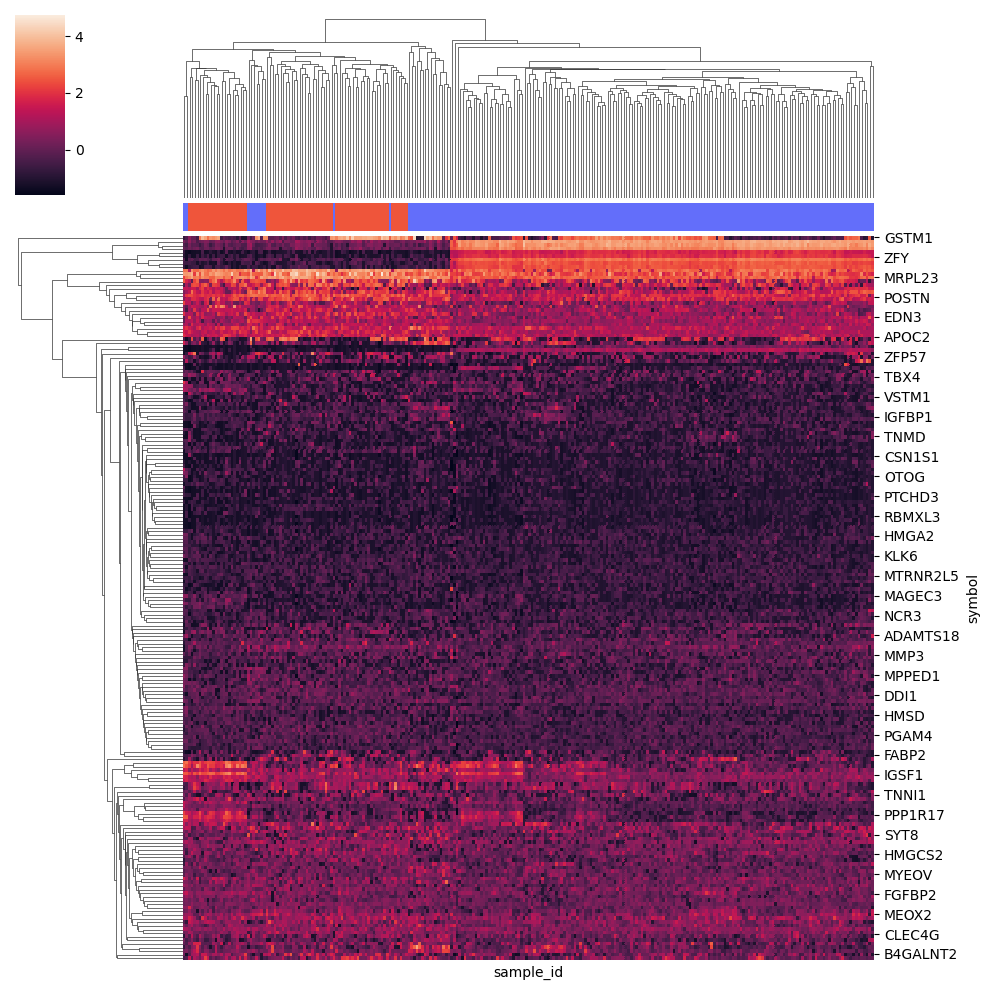

In [49]:
sns.clustermap(df_data_norm_heatmap_f,xticklabels=False,col_colors = heatmap_cluster_colors); plt.show()
figure_legend("Figure 10", "Heatmap of most differentially expressed genes", "Color coding along the top edge indicates cluster designation of the corresponding sample.")

##  7. Enrichment Analysis with Enrichr

Perform enrichment analysis for each cluster by querying the [Enrichr](https://maayanlab.cloud/Enrichr/) API. A link is provided to download the results. 

In [43]:
# Util functions
def enrichr_link_from_genes(genes, description='', enrichr_link='https://amp.pharm.mssm.edu/Enrichr'):
    ''' Functional access to Enrichr API
    '''
    time.sleep(1)
    resp = requests.post(enrichr_link + '/addList', files={
    'list': (None, '\n'.join(genes)),
    'description': (None, description),
    })
    if resp.status_code != 200:
        raise Exception('Enrichr failed with status {}: {}'.format(
          resp.status_code,
          resp.text,
        ))
    # wait a tinybit before returning link (backoff)
    time.sleep(3)
    result = resp.json()
    return dict(result, link=enrichr_link + '/enrich?dataset=' + resp.json()['shortId'])

def enrichr_get_top_results(userListId, bg, enrichr_link='https://amp.pharm.mssm.edu/Enrichr'):
    time.sleep(1)
    resp = requests.get(enrichr_link + '/enrich?userListId={}&backgroundType={}'.format(userListId, bg))
    if resp.status_code != 200:
        raise Exception('Enrichr failed with status {}: {}'.format(
          resp.status_code,
          resp.text,
        ))
    time.sleep(3)
    return pd.DataFrame(resp.json()[bg], columns=['rank', 'term', 'pvalue', 'zscore', 'combinedscore', 'overlapping_genes', 'adjusted_pvalue', '', ''])

In [44]:
# Get Enrichr links for each cluster
enrichr_links = {}

for cluster, (up_genes, dn_genes) in top_genes.items():
    up_link, dn_link = None, None
    if up_genes.size:
        try:
            up_link = enrichr_link_from_genes(up_genes, f'cluster {cluster} up')
        except:
            print(f'Enrichr failed for cluster {cluster} up genes')
    else:
        print(f'cluster {cluster} up: empty')
    if dn_genes.size:
        try:
            dn_link = enrichr_link_from_genes(dn_genes, f'cluster {cluster} down')
        except:
            print(f'Enrichr failed for cluster {cluster} down genes')
    else:
        print(f'cluster {cluster} down: empty')
    enrichr_links[cluster] = (up_link, dn_link)

# Grab top results for each cluster
all_enrichr_results = []
for cluster, (up_link, dn_link) in enrichr_links.items():
    for link_type, link in [('up', up_link), ('down', dn_link)]:
        if link is None:
            continue
        for category, libraries in enrichr_libraries.items():
            for library in libraries:
                try:
                    results = enrichr_get_top_results(link['userListId'], library).sort_values('pvalue').iloc[:top_n_results]
                    results['link'] = link['link']
                    results['library'] = library
                    results['category'] = category
                    results['direction'] = link_type
                    results['cluster'] = cluster
                    all_enrichr_results.append(results)
                except:
                    print('{}: {} {} {} cluster {} failed, continuing'.format(link, library, category, link_type, cluster))

df_enrichr_results = pd.concat(all_enrichr_results).reset_index()

In [45]:
# Display a dataframe with clickable enrichr links
figure_legend("Table 11","Enrichment analysis results from Enrichr", "Results are grouped by expression direction (up/down) and gene set library. Within groups, results are sorted by lowest p-value (highest rank) first.")
df_clickable = df_enrichr_results.copy()
df_clickable['link'] = df_clickable["link"].apply(make_clickable)
table_html = df_clickable.to_html(escape=False)
display(HTML(f'<div style="max-height: 250px; overflow-y: auto; margin-bottom: 25px;">{table_html}</div>'))
download_button(df_enrichr_results.to_csv(), 'Download Enrichr results', 'Enrichr results.csv')

,index,rank,term,pvalue,zscore,combinedscore,overlapping_genes,adjusted_pvalue,,,link,library,category,direction,cluster
0,0,1,Osteoarthritis biomarkers,0.004146,20.000000,109.710142,"[COMP, CSMD1]",1.000000,0,0,https://amp.pharm.mssm.edu/Enrichr/enrich?dataset=a4df04a81d7068392e952da1ba096cd1,GWAS_Catalog_2019,Diseases/Drugs,up,0
1,1,2,Response to TNF antagonist treatment,0.004146,20.000000,109.710142,"[PON1, CST5]",1.000000,0,0,https://amp.pharm.mssm.edu/Enrichr/enrich?dataset=a4df04a81d7068392e952da1ba096cd1,GWAS_Catalog_2019,Diseases/Drugs,up,0
2,2,3,Fast beta electroencephalogram,0.006555,16.000000,80.440660,"[UROC1, ZBBX]",1.000000,0,0,https://amp.pharm.mssm.edu/Enrichr/enrich?dataset=a4df04a81d7068392e952da1ba096cd1,GWAS_Catalog_2019,Diseases/Drugs,up,0
3,3,4,Rheumatoid arthritis,0.008078,3.076923,14.826409,"[ACOXL, P2RY10, UBASH3A, PADI4, CSMD3, SMTNL2, ICOSLG]",1.000000,0,0,https://amp.pharm.mssm.edu/Enrichr/enrich?dataset=a4df04a81d7068392e952da1ba096cd1,GWAS_Catalog_2019,Diseases/Drugs,up,0
4,4,5,Severe malaria (adjusted for sickle cell variant rs334),0.011085,12.307692,55.411328,"[TREML4, CSMD1]",1.000000,0,0,https://amp.pharm.mssm.edu/Enrichr/enrich?dataset=a4df04a81d7068392e952da1ba096cd1,GWAS_Catalog_2019,Diseases/Drugs,up,0
5,0,1,response to alcohol (GO:0097305),0.000245,12.800000,106.412241,"[TH, CCL3, CSN1S1, GRIN2B]",1.000000,0,0,https://amp.pharm.mssm.edu/Enrichr/enrich?dataset=a4df04a81d7068392e952da1ba096cd1,GO_Biological_Process_2018,Ontologies,up,0
6,1,2,inflammatory response (GO:0006954),0.000347,3.492063,27.814032,"[NCR3, CXCL9, KLK1, NLRP4, CCL4, CCL3, PROK2, PPBP, HPR, SCG2, SELE]",0.886485,0,0,https://amp.pharm.mssm.edu/Enrichr/enrich?dataset=a4df04a81d7068392e952da1ba096cd1,GO_Biological_Process_2018,Ontologies,up,0
7,2,3,cell-cell adhesion via plasma-membrane adhesion molecules (GO:0098742),0.000424,4.507042,35.003143,"[CLDN6, CLDN10, NCR3, CDH1, CLDN14, UNC5D, SELE, CD177]",0.720831,0,0,https://amp.pharm.mssm.edu/Enrichr/enrich?dataset=a4df04a81d7068392e952da1ba096cd1,GO_Biological_Process_2018,Ontologies,up,0
8,3,4,regulation of sodium ion transmembrane transporter activity (GO:2000649),0.001138,8.648649,58.622594,"[NETO1, FXYD4, FXYD3, PCSK9]",1.000000,0,0,https://amp.pharm.mssm.edu/Enrichr/enrich?dataset=a4df04a81d7068392e952da1ba096cd1,GO_Biological_Process_2018,Ontologies,up,0
9,4,5,potassium ion import (GO:0010107),0.001260,8.421053,56.225470,"[SLC12A3, KCNJ13, ATP1A4, KCNJ1]",1.000000,0,0,https://amp.pharm.mssm.edu/Enrichr/enrich?dataset=a4df04a81d7068392e952da1ba096cd1,GO_Biological_Process_2018,Ontologies,up,0


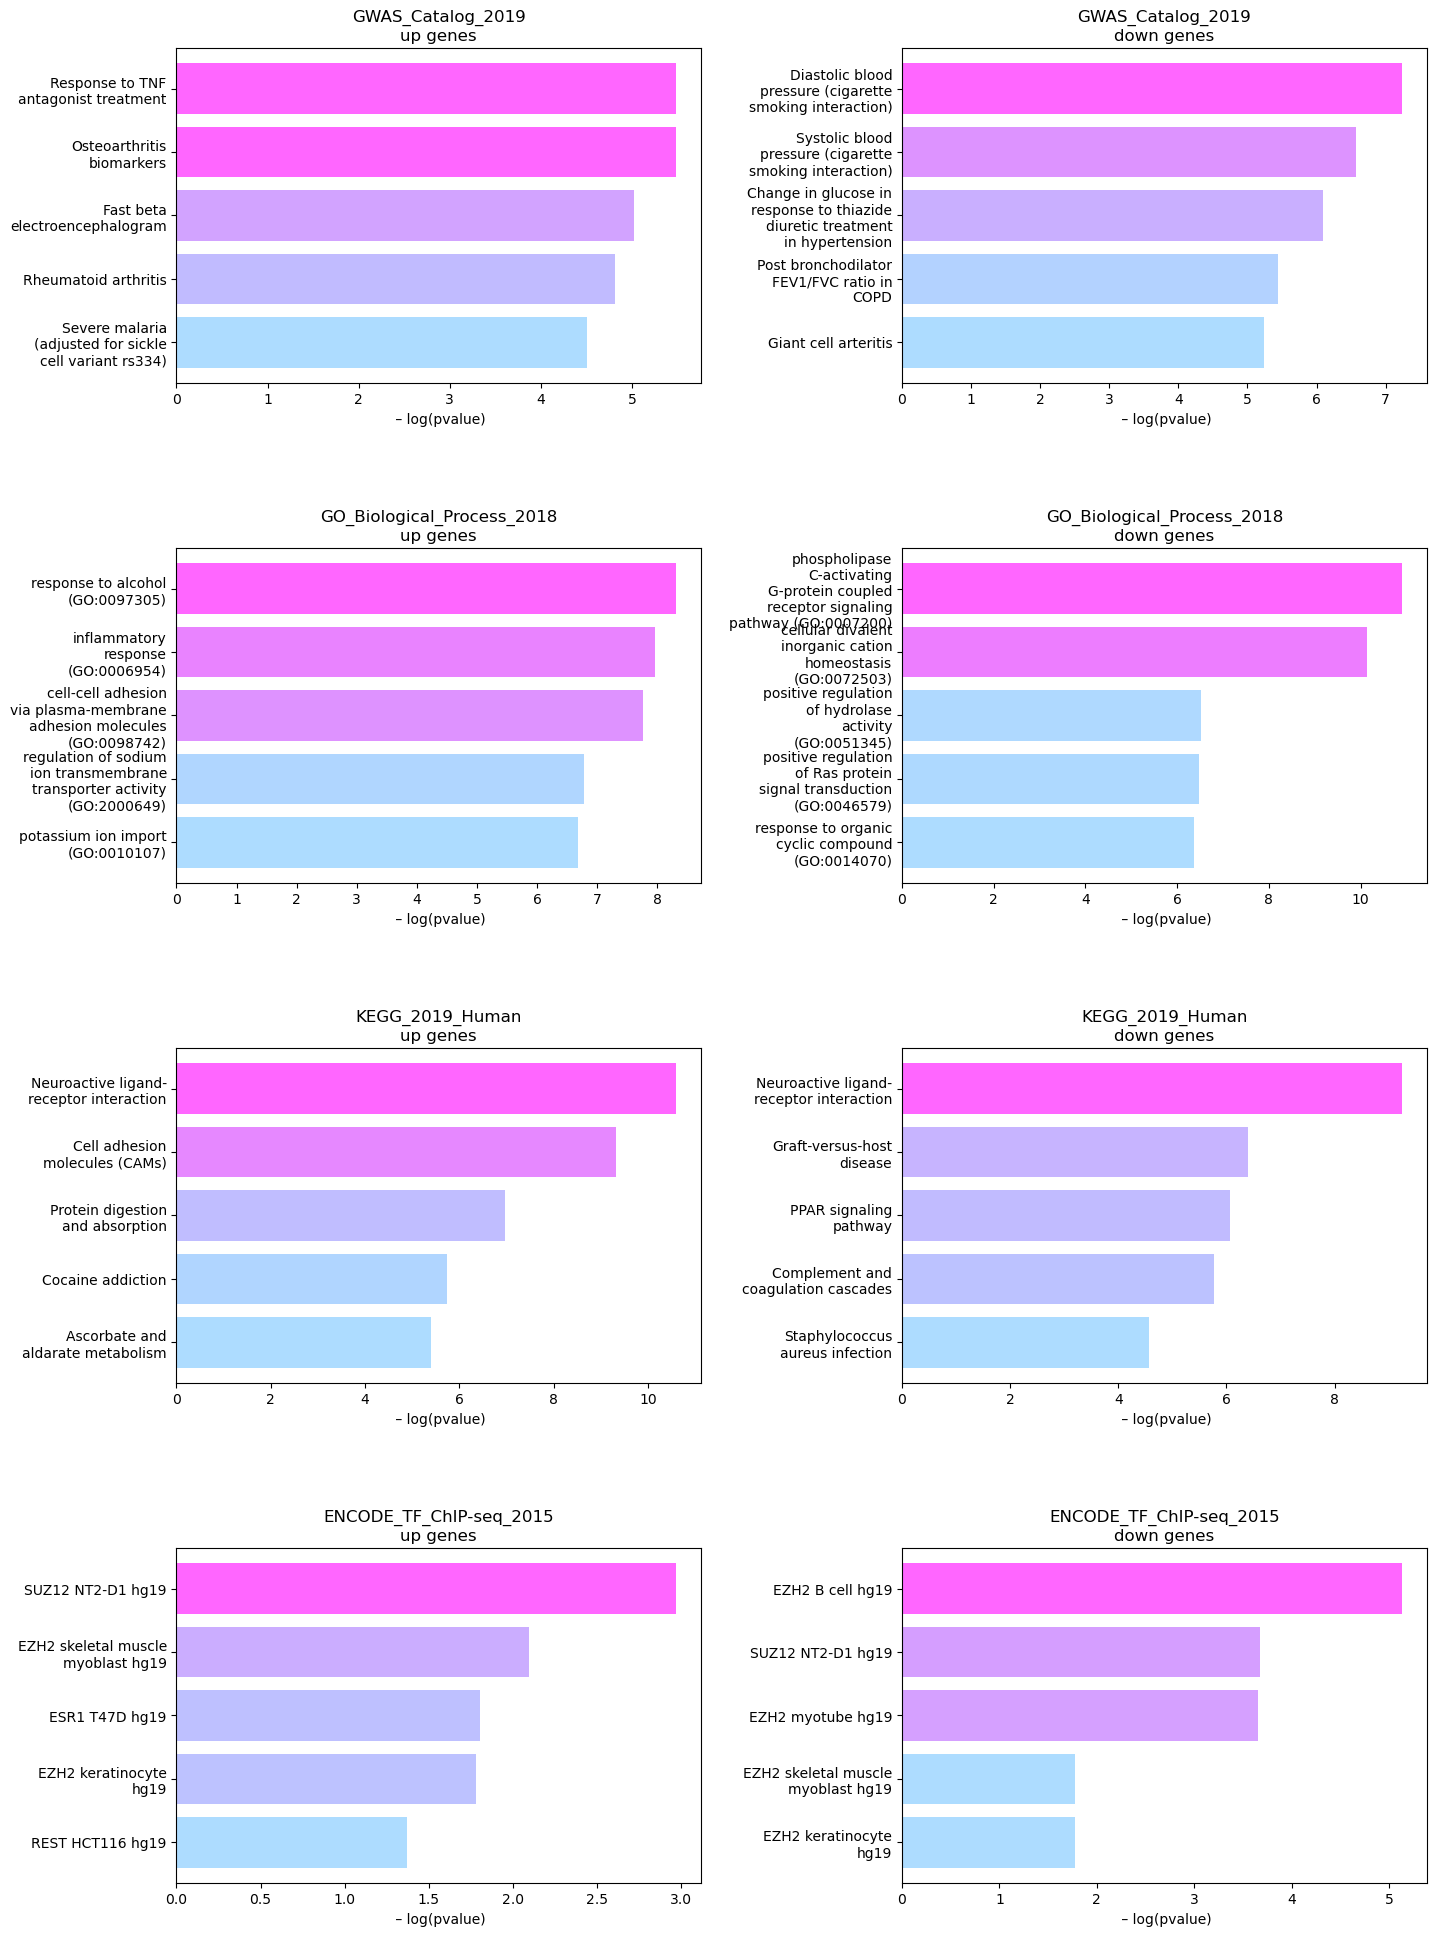

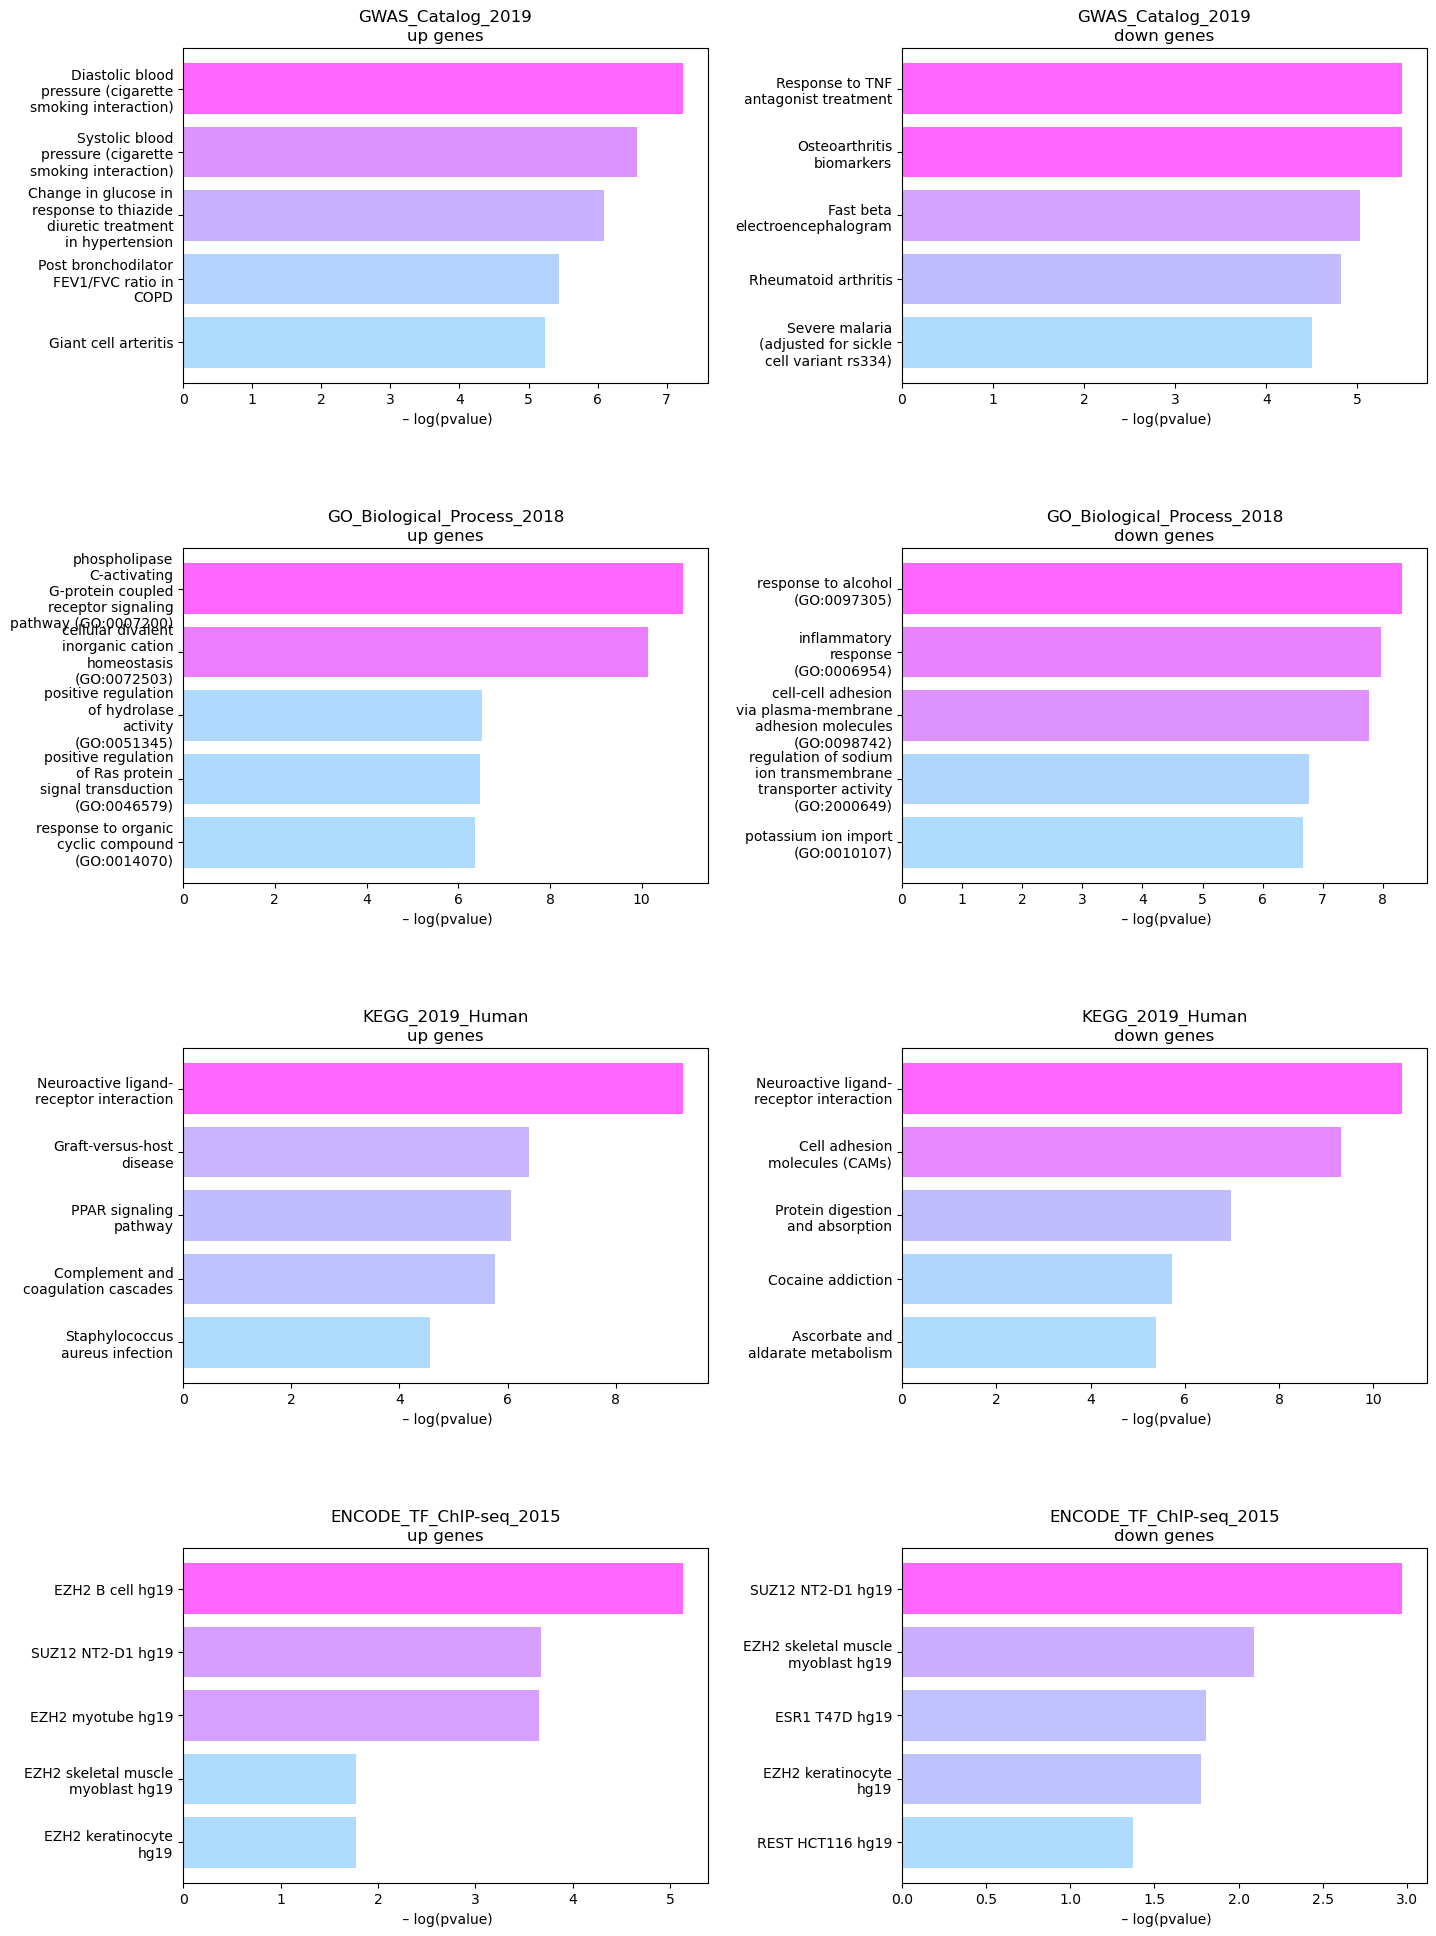

In [46]:
# Make horizontal barplots to visualize top Enrichr results
clusters = df_enrichr_results["cluster"].unique()
for cluster in clusters:
    cluster_results = df_enrichr_results.loc[df_enrichr_results["cluster"] == cluster, :]
    libraries = cluster_results["library"].unique()
    num_rows = len(libraries)

    count = 1 # keep track of which subplot we're on
    fig = plt.figure(figsize=(15,5*num_rows))
    
    for library in cluster_results["library"].unique():
            library_results = cluster_results.loc[cluster_results["library"] == library, :]
            for direction in library_results["direction"].unique():
                plot_results = library_results.loc[cluster_results["direction"] == direction, :]
                plot_results = plot_results.sort_values("pvalue",ascending=False)
                labels = plot_results["term"]
                labels = [ '\n'.join(wrap(l, 20)) for l in labels ]
                values = plot_results["pvalue"]
                values = -np.log(values)
                
                # normalize values to map from 0-1 -> color, with opacity also based on normalized pvalue
                cmap = plt.get_cmap('cool')
                norm_values = [ 0.3 + (x - min(values))/(max(values) - min(values))*0.7 for x in values]
                colors = [ [*cmap(val)[:3], 0.4  + 0.2*val] for val in norm_values]
                
                # plot result
                ax = fig.add_subplot(num_rows,2,count)
                ax.barh(labels,values,color = colors)
                ax.set_title(f'{library}\n{direction} genes')
                ax.set_xlabel(' – log(pvalue)')
                count += 1
                
    cluster_heading(cluster)
    #title = plt.suptitle(f'Cluster {cluster}',fontsize=24, color="white",bbox=(dict(facecolor=cluster_colors[cluster], alpha=0.8,pad=5)))
    fig.tight_layout(pad=3, w_pad=2, h_pad=6)
    plt.show()
    display(HTML("<br><br>"))
    
figure_legend("Figure 11", "Enrichment results by cluster", "Bar plots indicate the negative log of the p-value for the specified term. One plot is presented per cluster, per gene-set library, per expression direction (up/down).")

## 8. Drug Signature Querying with L1000FWD

Query the [L1000 Fireworks Display (L1000FWD)](https://amp.pharm.mssm.edu/L1000FWD/) API to find similar and opposite gene expression signatures from the L1000 database for each cluster, based on the up- and down-regulated genes. Links are provided to the L1000FWD interactive projection of the results for each cluster.

In [47]:
# Util functions
def l1000fwd_results_from_genes(up_genes, down_genes, description='', l100fwd_link='http://amp.pharm.mssm.edu/L1000FWD/'):
    ''' Functional access to L1000FWD API
    '''
    import time
    time.sleep(1)
    response = requests.post(l100fwd_link + 'sig_search', json={
    'up_genes': list(up_genes),
    'down_genes': list(down_genes),
    })
    l1000fwd_results =  {}
    if response.status_code != 200:
        raise Exception('L1000FWD failed with status {}: {}'.format(
          response.status_code,
          response.text,
        ))
    if 'KeyError' in response.text:
        l1000fwd_results['result_url'] = None
    else:
        # Get ID and URL
        result_id = response.json()['result_id']
        l1000fwd_results['result_url'] = 'https://amp.pharm.mssm.edu/l1000fwd/vanilla/result/'+result_id
        l1000fwd_results['result_id'] = result_id

        # Get Top
        l1000fwd_results['signatures'] = requests.get(l100fwd_link + 'result/topn/' + result_id).json()

    # wait a tinybit before returning link (backoff)
    time.sleep(1)
    return l1000fwd_results

def l1000fwd_sig_link(sig_id):
    return 'https://amp.pharm.mssm.edu/dmoa/sig/' + sig_id

def get_signature_by_id(sig_id):
    response = requests.get("http://amp.pharm.mssm.edu/L1000FWD/sig/" + sig_id)
    if response.status_code != 200:
        raise Exception('L1000FWD signature query  failed with status {}: {}'.format(
          response.status_code,
          response.text,
        ))
    return response.json()

In [48]:
def display_l1000fwd_results(l1000fwd_results, plot_counter,cluster_id,nr_drugs=7, height=300):
    # Check if results
    if l1000fwd_results['result_url']:

        # Display cluster title
        display(HTML('<br><br>'))
        cluster_heading(cluster)

        # Display IFrae
        display(HTML(f"<a href='{l1000fwd_results['result_url']}' target='_blank'> View L1000FWD for cluster {cluster_id}</a>"))
    
        # Display tables
        for direction, signature_list in l1000fwd_results['signatures'].items():

            # Fix dataframe
            rename_dict = {'sig_id': 'Signature ID', 'pvals': 'P-value', 'qvals': 'FDR', 'zscores': 'Z-score', 'combined_scores': 'Combined Score'}
            signature_dataframe = pd.DataFrame(signature_list)[list(rename_dict.keys())].rename(columns=rename_dict).sort_values('P-value').rename_axis('Rank')
            signature_dataframe.index = [x + 1 for x in range(len(signature_dataframe.index))]
            signature_csv = signature_dataframe.to_csv(sep=",")

            # Display table
            pd.set_option('max.colwidth', None)
            signature_dataframe['Signature ID'] = [f'<a href={l1000fwd_sig_link(x)} target="_blank">{x}</a>' for x in signature_dataframe['Signature ID']]
            table_html = signature_dataframe.to_html(escape=False, classes='w-100')
            display(HTML(f'<h3>{direction.title()} Signatures: </h3>'))
            display(HTML(f'<style>.w-100{{width: 100% !important;}}</style><div style="max-height: 250px; overflow-y: auto; margin-bottom: 25px;">{table_html}</div>'))

            # Display download button
            download_button(signature_csv, f'Download {direction.title()} Signatures', f'Cluster {cluster_id} L1000FWD {direction.title()} signatures.csv')
        # Link
        display(HTML('Full results available at: <a href="{result_url}" target="_blank">{result_url}</a>.'.format(**l1000fwd_results)))
        
    # Display error
    else:
        display(Markdown('### No results were found.\n This is likely due to the fact that the gene identifiers were not recognized by L1000FWD. Please note that L1000FWD currently only supports HGNC gene symbols (https://www.genenames.org/). If a dataset uses other gene identifier systems, such as Ensembl IDs or Entrez IDs, consider converting them to HGNC. Automated gene identifier conversion is currently under development.'))


In [49]:
plot_counter = 0
all_l1000fwd_results = {}

for cluster, (up_genes, dn_genes) in top_genes.items():
    try:
        results = l1000fwd_results_from_genes(up_genes,dn_genes)
        all_l1000fwd_results[cluster] = results
        figure_legend("Table 12", "Similar and opposite L1000 signatures by cluster", "Results are sorted by lowest p-value.")
        display_l1000fwd_results(results,plot_counter,cluster)
        plot_counter += 1
    except:
        print(f'L1000FWD API failed for cluster {cluster}, continuing')

,Signature ID,P-value,FDR,Z-score,Combined Score
1,CPC007_HT29_6H:BRD-A09719808-001-02-3:10,4.831459e-08,0.002068,-1.719572,12.580252
2,CPC014_HT29_6H:BRD-K83837640-001-01-4:10,1.250789e-05,0.066931,-1.797267,8.811667
3,CPC019_VCAP_6H:BRD-K43226598-001-01-1:10,2.526932e-05,0.073570,-1.796973,8.261417
4,CPC020_MCF7_24H:BRD-A80638690-001-02-8:10,2.593423e-05,0.073570,-1.813418,8.316563
5,CPC019_HT29_6H:BRD-K71138616-001-01-1:10,2.902362e-05,0.073570,-1.920738,8.714868
6,CPC006_MCF7_24H:BRD-K93754473-001-06-0:28.39,3.103930e-05,0.073570,-1.663298,7.498292
7,CPC011_VCAP_6H:BRD-K82036761-003-12-0:10,3.119228e-05,0.073570,-1.751458,7.891987
8,CPC011_VCAP_24H:BRD-K63343048-001-07-2:10,4.077069e-05,0.085382,-1.740508,7.640225
9,CPC009_PC3_6H:BRD-K97534490-001-06-1:10,4.893236e-05,0.090715,-1.740894,7.503956
10,CPC019_PC3_6H:BRD-K33116223-001-01-9:10,8.884126e-05,0.118038,-1.758646,7.124951


,Signature ID,P-value,FDR,Z-score,Combined Score
1,CPC019_VCAP_6H:BRD-K43682718-001-01-0:10,3.041485e-07,0.004340,1.689555,-11.010683
2,CPC014_PC3_24H:BRD-K13566078-003-01-1:10,6.148450e-05,0.105284,1.674776,-7.052874
3,CPC004_VCAP_24H:BRD-K43068349-001-01-9:10,8.467355e-05,0.116929,1.811733,-7.377833
4,CPC007_VCAP_6H:BRD-K88198340-001-05-0:10,2.104154e-04,0.169233,1.807623,-6.646489
5,CPC015_MCF7_6H:BRD-A83326220-001-04-2:10,2.637264e-04,0.177069,1.713401,-6.131999
6,CPC019_VCAP_6H:BRD-K00289828-001-05-3:10,2.647208e-04,0.177069,1.726740,-6.176917
7,CPC014_HA1E_6H:BRD-K40255344-001-13-5:10,3.009854e-04,0.181477,1.721795,-6.063224
8,CPC004_VCAP_24H:BRD-K28307902-001-09-2:10,3.282605e-04,0.189899,1.810459,-6.307245
9,CPC013_MCF7_24H:BRD-K17743125-001-03-5:10,3.653113e-04,0.205771,1.727182,-5.936907
10,CPC019_HT29_6H:BRD-K76999748-001-01-2:10,3.757290e-04,0.208891,1.725898,-5.911417


,Signature ID,P-value,FDR,Z-score,Combined Score
1,CPC019_VCAP_6H:BRD-K43682718-001-01-0:10,3.041485e-07,0.004340,-1.796163,11.705438
2,CPC014_PC3_24H:BRD-K13566078-003-01-1:10,6.148450e-05,0.105284,-1.704488,7.177999
3,CPC004_VCAP_24H:BRD-K43068349-001-01-9:10,8.467355e-05,0.116929,-1.652323,6.728677
4,CPC007_VCAP_6H:BRD-K88198340-001-05-0:10,2.104154e-04,0.169233,-1.703616,6.264063
5,CPC015_MCF7_6H:BRD-A83326220-001-04-2:10,2.637264e-04,0.177069,-1.777335,6.360808
6,CPC019_VCAP_6H:BRD-K00289828-001-05-3:10,2.647208e-04,0.177069,-1.858644,6.648763
7,CPC014_HA1E_6H:BRD-K40255344-001-13-5:10,3.009854e-04,0.181477,-1.749967,6.162430
8,CPC004_VCAP_24H:BRD-K28307902-001-09-2:10,3.282605e-04,0.189899,-1.634339,5.693681
9,CPC013_MCF7_24H:BRD-K17743125-001-03-5:10,3.653113e-04,0.205771,-1.704807,5.859994
10,CPC019_HT29_6H:BRD-K76999748-001-01-2:10,3.757290e-04,0.208891,-1.839350,6.300004


,Signature ID,P-value,FDR,Z-score,Combined Score
1,CPC007_HT29_6H:BRD-A09719808-001-02-3:10,4.831459e-08,0.002068,1.799247,-13.163148
2,CPC014_HT29_6H:BRD-K83837640-001-01-4:10,1.250789e-05,0.066931,1.743846,-8.549756
3,CPC019_VCAP_6H:BRD-K43226598-001-01-1:10,2.526932e-05,0.073570,1.669724,-7.676398
4,CPC020_MCF7_24H:BRD-A80638690-001-02-8:10,2.593423e-05,0.073570,1.660570,-7.615583
5,CPC019_HT29_6H:BRD-K71138616-001-01-1:10,2.902362e-05,0.073570,1.771136,-8.036083
6,CPC006_MCF7_24H:BRD-K93754473-001-06-0:28.39,3.103930e-05,0.073570,1.765336,-7.958289
7,CPC011_VCAP_6H:BRD-K82036761-003-12-0:10,3.119228e-05,0.073570,1.813364,-8.170931
8,CPC011_VCAP_24H:BRD-K63343048-001-07-2:10,4.077069e-05,0.085382,1.793819,-7.874240
9,CPC009_PC3_6H:BRD-K97534490-001-06-1:10,4.893236e-05,0.090715,1.806013,-7.784643
10,CPC019_PC3_6H:BRD-K33116223-001-01-9:10,8.884126e-05,0.118038,1.684057,-6.822762


### 8a. Drug Suggestions
The opposite signatures of a given cluster provide suggestions for a set of drugs that may perturb a cluster and present potential treatments for disease states in which the original signature is present.

In [50]:
df_drugs = pd.read_csv("https://amp.pharm.mssm.edu/l1000fwd/download/Drugs_metadata.csv")

# Load top drug suggestions for each cluster based on the drugs used to produce the top_n_drugs opposite signatures
drug_results = {}
for cluster, results in all_l1000fwd_results.items():
    opposite_sigs = results["signatures"]["opposite"][:top_n_drugs]
    sig_ids = [sig["sig_id"] for sig in opposite_sigs]
    pert_ids = []
    for sig_id in sig_ids:
        try:
            signature = get_signature_by_id(sig_id)
            pert_ids.append(signature["pert_id"])
        except: 
            print(f'L1000FWD API failed for cluster {cluster}, sig_id {sig_id}, continuing')
    
    df_cluster_drugs = df_drugs[df_drugs["pert_id"].isin(pert_ids)].copy()
    df_cluster_drugs["cluster"] = cluster
    df_cluster_drugs = df_cluster_drugs[["cluster", *list(filter(lambda x: x!="cluster", df_cluster_drugs.columns))]]
    drug_results[cluster] = df_cluster_drugs
    
df_all_drugs = pd.concat(drug_results).reset_index()

In [51]:
# Display a dataframe with clickable L1000FWD links
figure_legend("Table 13", "Drugs used to produce most opposite signatures for each cluster", "Each entry is a drug or small molecule used for perturbation in the L1000 experiments, which resulted in a gene expression signature most opposite to that of the specified cluster.")
df_clickable = df_all_drugs.copy()
df_clickable['pert_url'] = df_clickable["pert_url"].apply(make_clickable)
table_html = df_clickable.to_html(escape=False)
display(HTML(f'<div style="max-height: 250px; overflow-y: auto; margin-bottom: 25px;">{table_html}</div>'))
download_button(df_all_drugs.to_csv(), 'Download L1000FWD drug results', 'L1000FWD drugs.csv')

,level_0,level_1,cluster,pert_id,LSM_id,pert_iname,alt_name,canonical_smiles,inchi_key,inchi_string,molecular_formula,molecular_wt,pert_collection,pert_summary,pert_url,pubchem_cid
0,0,745,0,BRD-K13566078,LSM-1028,BMS-345541,BMS-345541,Cc1cnc2c(NCCN)nc3ccc(C)cc3n12,InChIKey=PSPFQEBFYXJZEV-UHFFFAOYSA-N,"InChI=1S/C14H17N5/c1-9-3-4-11-12(7-9)19-10(2)8-17-14(19)13(18-11)16-6-5-15/h3-4,7-8H,5-6,15H2,1-2H3,(H,16,18)",C14H17N5,255.318,BIOA,NaN,nan,9813758
1,0,2663,0,BRD-K43068349,LSM-2953,AMG-9810,AMG-9810,CC(C)(C)c1ccc(C=CC(=O)Nc2ccc3OCCOc3c2)cc1,InChIKey=GZTFUVZVLYUPRG-UHFFFAOYSA-N,"InChI=1S/C21H23NO3/c1-21(2,3)16-7-4-15(5-8-16)6-11-20(23)22-17-9-10-18-19(14-17)25-13-12-24-18/h4-11,14H,12-13H2,1-3H3,(H,22,23)",C21H23NO3,337.412,BIOA,NaN,nan,680502
2,0,3397,0,BRD-A83326220,LSM-1844,brazilin,NaN,Oc1ccc2C3c4cc(O)c(O)cc4CC3(O)COc2c1,InChIKey=UWHUTZOCTZJUKC-UHFFFAOYSA-N,"InChI=1S/C16H14O5/c17-9-1-2-10-14(4-9)21-7-16(20)6-8-3-12(18)13(19)5-11(8)15(10)16/h1-5,15,17-20H,6-7H2",C16H14O5,286.279,BIOA,NaN,http://en.wikipedia.org/wiki/Brazilin,222515
3,0,10854,0,BRD-K43682718,NaN,SA-424589,SA-424589,C[C@H](CO)N1C[C@H](C)[C@H](CN(C)C(=O)CCCN(C)C)OCCCC[C@H](C)Oc2ccc(NS(=O)(=O)c3cccs3)cc2C1=O,InChIKey=YRAOJEGTHQJVGH-JLMYGFKKSA-N,"InChI=1S/C32H50N4O7S2/c1-23-20-36(24(2)22-37)32(39)27-19-26(33-45(40,41)31-13-10-18-44-31)14-15-28(27)43-25(3)11-7-8-17-42-29(23)21-35(6)30(38)12-9-16-34(4)5/h10,13-15,18-19,23-25,29,33,37H,7-9,11-12,16-17,20-22H2,1-6H3/t23-,24+,25-,29-/m0/s1",C32H50N4O7S2,666.892,CBLI,NaN,nan,44489864
4,0,18337,0,BRD-K88198340,LSM-3963,BRD-K88198340,NaN,COC1(OC)C=CC(=O)C=C1NC(=O)c2ccccc2OC(=O)C,InChIKey=NYHYQDXXVQAQGX-UHFFFAOYSA-N,"InChI=1S/C17H17NO6/c1-11(19)24-14-7-5-4-6-13(14)16(21)18-15-10-12(20)8-9-17(15,22-2)23-3/h4-10H,1-3H3,(H,18,21)",C17H17NO6,331.320,STRD,NaN,nan,12043281
5,1,1876,1,BRD-K83837640,LSM-5900,JNJ-26854165,JNJ-26854165,Cn1cc(CNCC2CCN(CC2)c2ncc(cn2)C(=O)NO)c2ccccc12,InChIKey=PAWIYAYFNXQGAP-UHFFFAOYSA-N,"InChI=1S/C21H26N6O2/c1-26-14-17(18-4-2-3-5-19(18)26)11-22-10-15-6-8-27(9-7-15)21-23-12-16(13-24-21)20(28)25-29/h2-5,12-15,22,29H,6-11H2,1H3,(H,25,28)",C21H26N6O2,394.470,BIOA,NaN,nan,11538455
6,1,2025,1,BRD-K93754473,LSM-2966,tamoxifen,ICI-46|S1238|S1972,CC/C(=C(c1ccccc1)/c2ccc(OCCN(C)C)cc2)/c3ccccc3,InChIKey=NKANXQFJJICGDU-QPLCGJKRSA-N,"InChI=1S/C26H29NO/c1-4-25(21-11-7-5-8-12-21)26(22-13-9-6-10-14-22)23-15-17-24(18-16-23)28-20-19-27(2)3/h5-18H,4,19-20H2,1-3H3/b26-25-",C26H29NO,371.515,BIOA,Tamoxifen Citrate is an antagonist of the estrogen receptor by competitive inhibition of estrogen binding.,"http://en.wikipedia.org/wiki/Tamoxifen,http://www.selleckchem.com/products/Tamoxifen-Citrate(Nolvadex).html",2733526
7,1,2427,1,BRD-A80638690,LSM-5157,floxuridine,NSC-27640|deoxyfluorouridine|S1299,OCC1OC(CC1O)n1cc(F)c(=O)[nH]c1=O,InChIKey=ODKNJVUHOIMIIZ-UHFFFAOYSA-N,"InChI=1S/C9H11FN2O5/c10-4-2-12(9(16)11-8(4)15)7-1-5(14)6(3-13)17-7/h2,5-7,13-14H,1,3H2,(H,11,15,16)",C9H11FN2O5,246.192,BIOA,Floxuridine (Fludara) is a prodrugs of floxuridine and an oncology agent with an GI50 of 5.1 μM for the inhibition of MDCK/PEPT1.,"http://en.wikipedia.org/wiki/Floxuridine,http://www.selleckchem.com/products/Floxuridine.html",3363
8,1,2916,1,BRD-A09719808,LSM-1300,BRD-A09719808,NaN,CCC(OC(=O)c1ccc(c(c1)[N+]([O-])=O)S(C)(=O)=O)C(=O)NC1C2CC3CC(C2)CC1C3,InChIKey=OKEYLXGAJZVHLC-UHFFFAOYSA-N,"InChI=1S/C22H28N2O7S/c1-3-18(21(25)23-20-15-7-12-6-13(9-15)10-16(20)8-12)31-22(26)14-4-5-19(32(2,29)30)17(11-14)24(27)28/h4-5,11-13,15-16,18,20H,3,6-10H2,1-2H3,(H,23,25)",C22H28N2O7S,464.532,STRD,NaN,nan,44640137
9,1,10766,1,BRD-K43226598,NaN,BRD-K43226598,NaN,C[C@H](CO)N1C[C@H](C)[C@@H](CN(C)Cc2ccc(cc2)c3ccccc3)Oc4ccc(NC(=O)CCCCCC(=O)Nc5ccccc5N)cc4CC1=O,InChIKey=VYCOOHAMPRTWAW-HYXMALDRSA-N,"InChI=1S/C43H53N5O5/c1-30-26-48(31(2)29-49)43(52)25-35-24-36(45-41(50)16-8-5-9-17-42(51)46-38-15-11-10-14-37(38)44)22-23-39(35)53-40(30)28-47(3)27-32-18-20-34(21-19-32)33-12-6-4-7-13-33/h4,6-7,10-15,18-24,30-31,40,49H,5,8-9,16-17,25-29,44H2,1-3H3,(H,45,50)(H,46,51)/t